---
#### Train
---

In [5]:
import pandas as pd
import os
import numpy as np
import time
import pickle
import warnings
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, GlobalMaxPool1D, SimpleRNN
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

---
#### 일단 네이블 통해 받은 데이터로 훈련을 한다.
---

In [6]:
ct = pd.read_csv('training-data-Slice01-20200118.csv')

In [7]:
ct

,SLICE,DATETIME,UPLINK_THROUGHPUT,DNLINK_THROUGHPUT,ACTIVE_USER
0,Slice01,2020-01-18T00:00:00,21690157,244798764,2556
1,Slice01,2020-01-18T00:05:00,23303153,234799993,2413
2,Slice01,2020-01-18T00:10:00,31590655,276907261,2463
3,Slice01,2020-01-18T00:15:00,19792626,235009752,2427
4,Slice01,2020-01-18T00:20:00,21312551,258244413,2373
...,...,...,...,...,...
687,Slice01,2020-01-20T09:40:00,59452828,625167856,3340
688,Slice01,2020-01-20T09:45:00,44974454,580920172,3840
689,Slice01,2020-01-20T09:50:00,48384076,477607952,3589
690,Slice01,2020-01-20T09:55:00,47639870,420845695,3145


In [8]:
import numpy as np
def create_dataset(signal_data, look_back = 144):
    dataX, dataY = [], []
    for i in range(len(signal_data)-156):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[(i + look_back):(i+156), 0])
    return np.array(dataX), np.array(dataY)

look_back = 144 ## 하루. 

train = ct[['DNLINK_THROUGHPUT']].values.reshape(-1,1)
x_train, y_train = create_dataset(train, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(144, return_sequences= True))
model.add(BatchNormalization())
model.add(SimpleRNN(144))
model.add(Dense(12, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
# mcp_save = ModelCheckpoint('/data01/CSB/CSB_Jupyter/PROBE/Pyfile/CSB-Modelling/10월16일/TANGO/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(x_train/1e8, y_train/1e8, epochs=10, batch_size = 2)

Epoch 1/10
536/536 [==============================] - 60s 111ms/step - loss: 6.6520
Epoch 2/10
536/536 [==============================] - 50s 94ms/step - loss: 1.2613
Epoch 3/10
536/536 [==============================] - 46s 85ms/step - loss: 1.1795
Epoch 4/10
536/536 [==============================] - 44s 83ms/step - loss: 1.0440
Epoch 5/10
536/536 [==============================] - 39s 74ms/step - loss: 0.9742
Epoch 6/10
536/536 [==============================] - 39s 72ms/step - loss: 0.8460
Epoch 7/10
536/536 [==============================] - 39s 73ms/step - loss: 0.8092
Epoch 8/10
536/536 [==============================] - 37s 69ms/step - loss: 0.8648
Epoch 9/10
536/536 [==============================] - 36s 68ms/step - loss: 0.8109
Epoch 10/10
536/536 [==============================] - 42s 79ms/step - loss: 0.7741


#### model 저장

In [23]:
model.save('Slice01-prediction-downlink-throughput.h5')

---
## 모델 제대로 돌아가는지 test 용
---

In [10]:
ct[['DNLINK_THROUGHPUT']][-144:]

,DNLINK_THROUGHPUT
548,418922501
549,455943474
550,460723148
551,430627344
552,345535701
...,...
687,625167856
688,580920172
689,477607952
690,420845695


In [17]:
prediction = ct[['DNLINK_THROUGHPUT']][0:144].values
    
    
result = model.predict(np.reshape(prediction,(1,144,1))/1e8)*1e8

In [18]:
result

array([[7.3890285e+08, 6.2656154e+08, 5.9499693e+08, 6.7228621e+08,
        7.5457286e+08, 8.3093856e+08, 7.6807718e+08, 7.0238944e+08,
        5.9057741e+08, 6.2381510e+08, 7.0140922e+08, 7.6674426e+08]],
      dtype=float32)

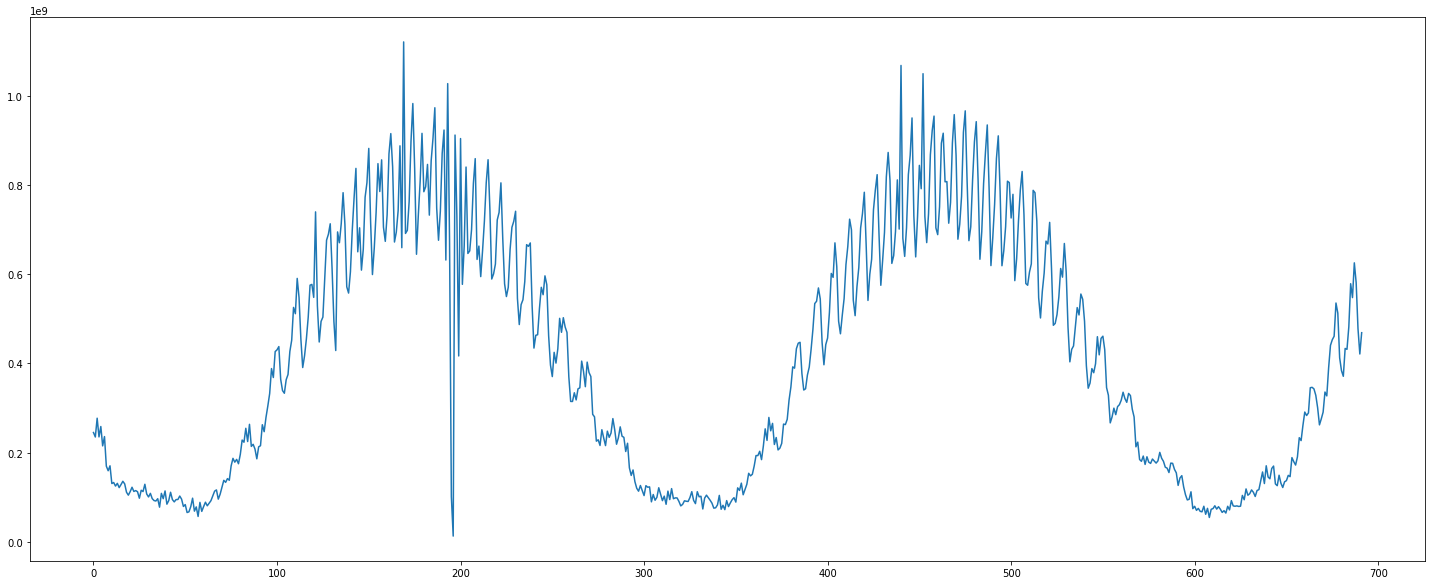

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.plot(ct[['DNLINK_THROUGHPUT']])
plt.show()

In [78]:
ct[['DNLINK_THROUGHPUT']]

,DNLINK_THROUGHPUT
0,629914474
1,632628181
2,515790887
3,503901049
4,469678345
...,...
279,432657132
280,397977329
281,426375570
282,483627944


In [20]:
test = pd.DataFrame(result[0])
test.columns =['DNLINK_THROUGHPUT']

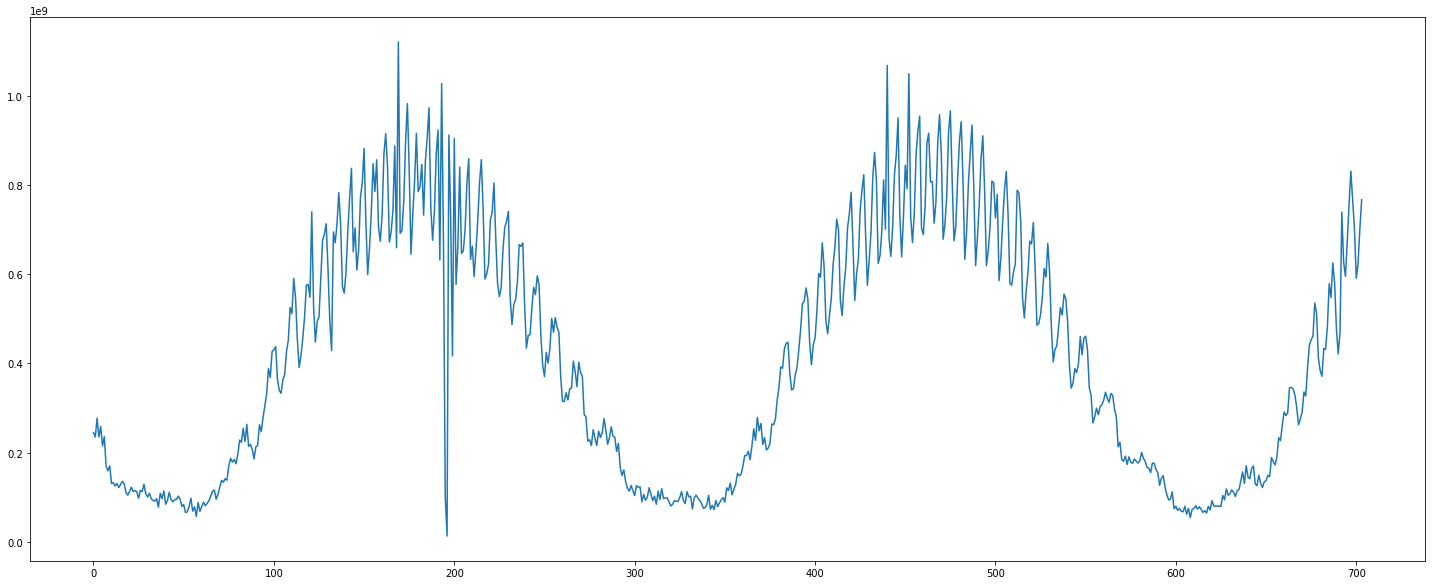

In [22]:
plt.figure(figsize=(25,10))
plt.plot(pd.concat([ct[['DNLINK_THROUGHPUT']],test]).reset_index(drop=True))

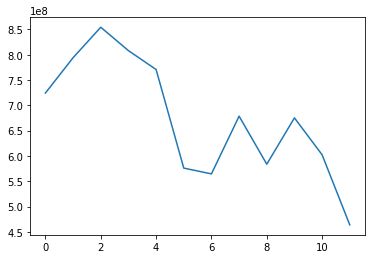

In [66]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(result[0])
